In [20]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable


In [21]:
import Augmentor

In [1]:
from pathlib import Path
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split as tts
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,MaxPool2D,GlobalMaxPool2D,Reshape,Dense,Dropout,BatchNormalization,Flatten
from keras import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.optimizers import Adam,Adamax,RMSprop,Nadam,SGD
from tensorflow.keras import layers

In [2]:
data_dir_train=pathlib.Path(r"F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test=pathlib.Path(r"F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

## Create Dataset

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualizate the data

### Todo, create a code to visualize one instance of all the nine classes present in the dataset

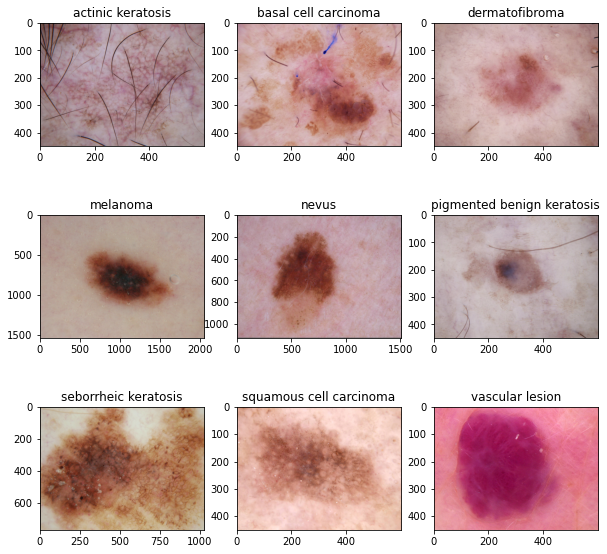

In [8]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
    plt.subplot(3, 3, i + 1)
    image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(image)


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [27]:
data_normalize=Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255)
])
def downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.99)(inputs)
    x = keras.layers.LeakyReLU(0.03)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(3)(x)
    
    return x

def resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.99)(inputs)
    x = keras.layers.LeakyReLU(0.03)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.99)(x)
    x = keras.layers.LeakyReLU(0.03)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 3))
    x=data_normalize(inputs)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = downsample(channels, x)
        for b in range(n_blocks):
            x = resblock(channels, x)
    x=Dropout(.25)(x)
    x = keras.layers.BatchNormalization(momentum=0.99)(x)
    x = keras.layers.LeakyReLU(0.03)(x)
    outputs = keras.layers.Conv2D(256,(1,1))(x)
    
    outputs=MaxPool2D((2,2))(outputs)
    outputs=Dropout(.25)(outputs)
    outputs = keras.layers.Conv2D(128,(3,3))(outputs)
    #outputs = keras.layers.Conv2D(64,(3,3),2)(outputs)
    #outputs = keras.layers.Conv2D(32,(3,3), 2)(outputs)
    #outputs = keras.layers.Conv2D(16,(3,3), 2)(outputs)
    outputs = keras.layers.Conv2D(64,(1,1))(outputs)

    
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [28]:
model = create_network(input_size=180, channels=64, n_blocks=1, depth=3)

In [29]:
headModel=model.output
headModel=Flatten()(headModel)
headModel=Dense(9,activation="softmax")(headModel)
model = Model(inputs=model.input, outputs=headModel)

In [30]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 180, 180, 64  1728        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 180, 180, 64  256        ['conv2d_23[0][0]']              
 ormalization)                  )                                                           

 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 6, 6, 512)    0           ['batch_normalization_18[0][0]'] 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 6, 6, 512)    2359296     ['leaky_re_lu_18[0][0]']         
                                                                                                  
 add_5 (Add)                    (None, 6, 6, 512)    0           ['conv2d_32[0][0]',              
                                                                  'max_pooling2d_14[0][0]']       
                                                                                                  
 dropout_4 (Dropout)            (None, 6, 6, 512)    0           ['add_5[0][0]']                  
          

### Compile the model

In [31]:
opt=Adam(learning_rate=2.0000e-04)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=['accuracy']) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{accuracy:.2f}.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             #save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_accuracy", patience=7, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, min_lr=1e-10, verbose=1, mode="max")

### Train the model

In [32]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[ stop, reduce_lr]
)

Epoch 1/30
56/56 [==============================] - 119s 2s/step - loss: 2.1374 - accuracy: 0.3811 - val_loss: 3.7394 - val_accuracy: 0.1834 - lr: 2.0000e-04
Epoch 2/30
56/56 [==============================] - 119s 2s/step - loss: 1.5332 - accuracy: 0.4888 - val_loss: 2.7887 - val_accuracy: 0.2707 - lr: 2.0000e-04
Epoch 3/30
56/56 [==============================] - 119s 2s/step - loss: 1.2508 - accuracy: 0.5910 - val_loss: 1.7880 - val_accuracy: 0.3893 - lr: 2.0000e-04
Epoch 4/30
56/56 [==============================] - 119s 2s/step - loss: 1.0754 - accuracy: 0.6205 - val_loss: 1.5158 - val_accuracy: 0.4541 - lr: 2.0000e-04
Epoch 5/30
56/56 [==============================] - 119s 2s/step - loss: 0.8870 - accuracy: 0.6780 - val_loss: 1.3321 - val_accuracy: 0.5056 - lr: 2.0000e-04
Epoch 6/30
56/56 [==============================] - 120s 2s/step - loss: 0.7907 - accuracy: 0.7087 - val_loss: 1.6100 - val_accuracy: 0.5280 - lr: 2.0000e-04
Epoch 7/30
56/56 [==============================] - 

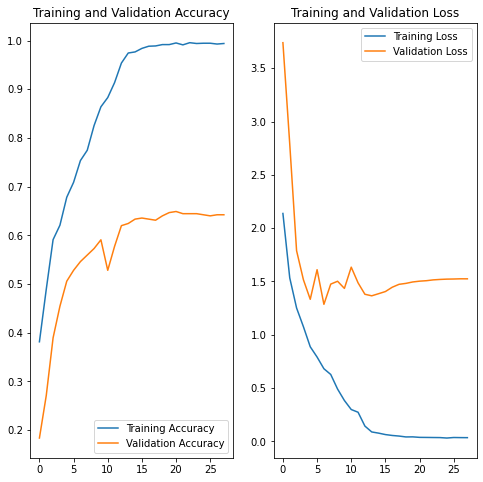

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

There is a clear indication of overfitting , but the lifecycle of model for training and validation set is same , the accuracy rises till around 8th epoch , after 10th epoch the learning becomes saturated which is shown both by train and validation accuracy.

The only difference is that the validation set , model was bit volatile.

### Choose data augmentation technique

In [10]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.Rescaling(1./255),
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])


### Create model

In [11]:

def downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.99)(inputs)
    x = keras.layers.LeakyReLU(0.03)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(3)(x)
    
    return x

def resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.99)(inputs)
    x = keras.layers.LeakyReLU(0.03)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.99)(x)
    x = keras.layers.LeakyReLU(0.03)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 3))
    x=data_augument(inputs)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = downsample(channels, x)
        for b in range(n_blocks):
            x = resblock(channels, x)
    x=Dropout(.25)(x)
    x = keras.layers.BatchNormalization(momentum=0.99)(x)
    x = keras.layers.LeakyReLU(0.03)(x)
    outputs = keras.layers.Conv2D(256,(1,1))(x)
    
    outputs=MaxPool2D((2,2))(outputs)
    outputs=Dropout(.25)(outputs)
    outputs = keras.layers.Conv2D(128,(3,3))(outputs)
    #outputs = keras.layers.Conv2D(64,(3,3),2)(outputs)
    #outputs = keras.layers.Conv2D(32,(3,3), 2)(outputs)
    #outputs = keras.layers.Conv2D(16,(3,3), 2)(outputs)
    outputs = keras.layers.Conv2D(64,(1,1))(outputs)

    
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
model = create_network(input_size=180, channels=16, n_blocks=1, depth=3)
headModel=model.output
headModel=Flatten()(headModel)
headModel=Dense(9,activation="softmax")(headModel)
model = Model(inputs=model.input, outputs=headModel)

In [13]:
opt=Adam(learning_rate=2.0000e-04)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=['accuracy']) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{accuracy:.2f}.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             #save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_accuracy", patience=7, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, min_lr=1e-10, verbose=1, mode="max")

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[ stop, reduce_lr]
)

Epoch 1/20


C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 28s 457ms/step - loss: 2.1254 - accuracy: 0.3125 - val_loss: 2.2728 - val_accuracy: 0.2081 - lr: 2.0000e-04
Epoch 2/20
56/56 [==============================] - 25s 447ms/step - loss: 1.5237 - accuracy: 0.4821 - val_loss: 1.9964 - val_accuracy: 0.2774 - lr: 2.0000e-04
Epoch 3/20
56/56 [==============================] - 25s 446ms/step - loss: 1.2917 - accuracy: 0.5564 - val_loss: 1.7984 - val_accuracy: 0.3356 - lr: 2.0000e-04
Epoch 4/20
56/56 [==============================] - 25s 444ms/step - loss: 1.1247 - accuracy: 0.5971 - val_loss: 1.5975 - val_accuracy: 0.4855 - lr: 2.0000e-04
Epoch 5/20
56/56 [==============================] - 25s 446ms/step - loss: 0.9928 - accuracy: 0.6468 - val_loss: 1.4673 - val_accuracy: 0.5011 - lr: 2.0000e-04
Epoch 6/20
56/56 [==============================] - 25s 444ms/step - loss: 0.7949 - accuracy: 0.7232 - val_loss: 1.4071 - val_accuracy: 0.4966 - lr: 2.0000e-04
Epoch 7/20
56/56 [==============================] -

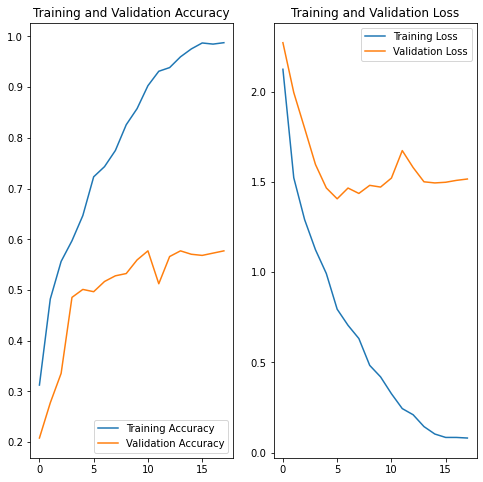

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We see the model keeps on learning over training set , the accuracy does not get saturated , it keeps on increasing, but after 3rd epoch the accuracy saturates on validation data

## Find the distribution of classes in the training dataset.

In [16]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
1,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
2,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
3,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
4,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
...,...,...
2234,F:\Python Works\Malenoma Detection\Malenoma\Sk...,vascular lesion
2235,F:\Python Works\Malenoma Detection\Malenoma\Sk...,vascular lesion
2236,F:\Python Works\Malenoma Detection\Malenoma\Sk...,vascular lesion
2237,F:\Python Works\Malenoma Detection\Malenoma\Sk...,vascular lesion


In [17]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
1,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
2,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
3,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
4,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
...,...,...
2234,F:\Python Works\Malenoma Detection\Malenoma\Sk...,vascular lesion
2235,F:\Python Works\Malenoma Detection\Malenoma\Sk...,vascular lesion
2236,F:\Python Works\Malenoma Detection\Malenoma\Sk...,vascular lesion
2237,F:\Python Works\Malenoma Detection\Malenoma\Sk...,vascular lesion


<BarContainer object of 9 artists>

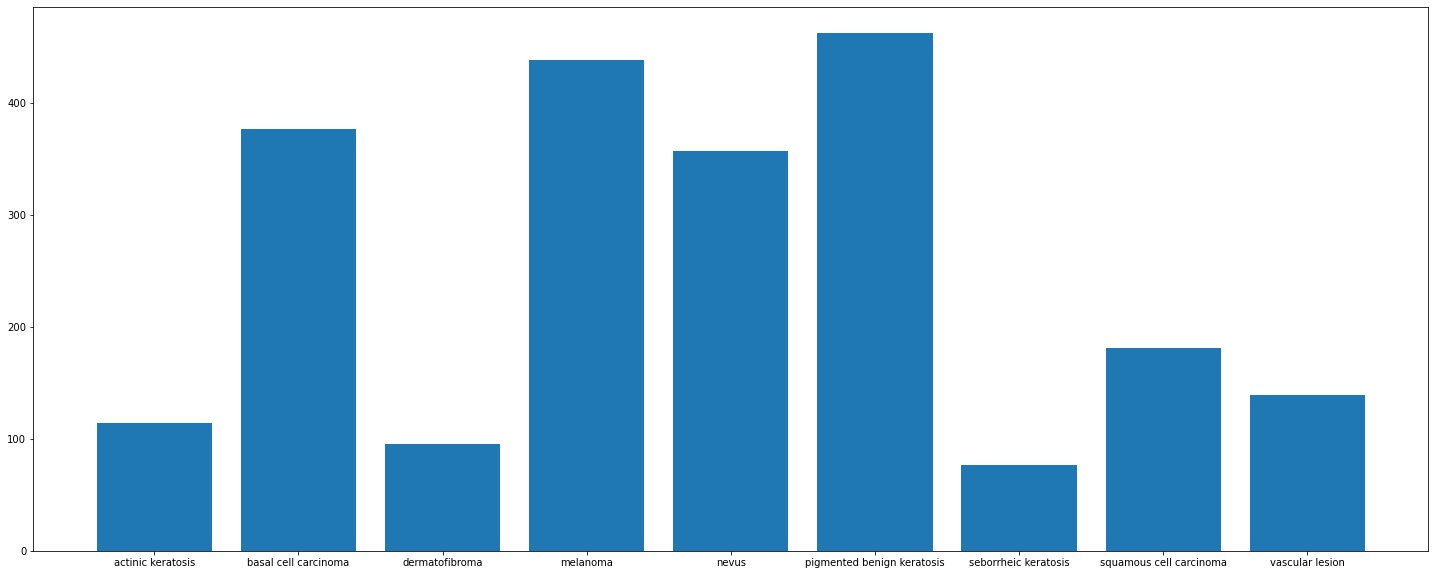

In [18]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

- **Which class has the least number of samples?**
- **Which classes dominate the data in terms proportionate number of samples?**

Answer-1 :- squamous cell carcinoma has least number of samples

Answer-2:- actinic keratosis and dermatofibroma have proportionate number of classes. melanoma and pigmented benign keratosis have proprtionate number of classes

### Rectify the class imbalance

In [22]:
for i in class_names:
    p = Augmentor.Pipeline(r"F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x207FC417280>: 100%|█| 500/500 [00:03<00:00, 159.12 Samples


Initialised with 2239 image(s) found.
Output directory set to F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x207F6C6F100>: 100%|█| 500/500 [00:03<00:00, 135.09 Samples


Initialised with 2239 image(s) found.
Output directory set to F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x207F634F760>: 100%|█| 500/500 [00:04<00:00, 102.57 Samples


Initialised with 2239 image(s) found.
Output directory set to F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\output.

Processing <PIL.Image.Image image mode=RGB size=963x629 at 0x207FA098F40>: 100%|█| 500/500 [00:04<00:00, 113.38 Samples


Initialised with 2239 image(s) found.
Output directory set to F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x207F69C93A0>: 100%|█| 500/500 [00:04<00:00, 105.16 Samples


Initialised with 2239 image(s) found.
Output directory set to F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x207FA07E580>: 100%|█| 500/500 [00:05<00:00, 97.02 Samples


Initialised with 2239 image(s) found.
Output directory set to F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x207F6BEC550>: 100%|█| 500/500 [00:05<00:00, 90.52 Samples/


Initialised with 2239 image(s) found.
Output directory set to F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x207FA16D1C0>: 100%|█| 500/500 [00:06<00:


Initialised with 2239 image(s) found.
Output directory set to F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x207F81D37C0>: 100%|█| 500/500 [00:05<00:00, 97.69 Samples


In [23]:
#Distribution of augmented data set
data_dir_train1 = pathlib.Path("F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [24]:
for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
1,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
2,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
3,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
4,F:\Python Works\Malenoma Detection\Malenoma\Sk...,actinic keratosis
...,...,...
6734,F:\Python Works\Malenoma Detection\Malenoma\Sk...,vascular lesion
6735,F:\Python Works\Malenoma Detection\Malenoma\Sk...,vascular lesion
6736,F:\Python Works\Malenoma Detection\Malenoma\Sk...,vascular lesion
6737,F:\Python Works\Malenoma Detection\Malenoma\Sk...,vascular lesion


In [25]:
new_df['Label'].value_counts()

melanoma                      1365
pigmented benign keratosis    1357
basal cell carcinoma          1146
nevus                         1062
squamous cell carcinoma        520
vascular lesion                435
actinic keratosis              340
dermatofibroma                 294
seborrheic keratosis           220
Name: Label, dtype: int64

In [31]:
data_dir_train1=pathlib.Path(r"F:\Python Works\Malenoma Detection\Malenoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

6739


In [32]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Final Model

In [34]:
#Data Augmentation 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.Rescaling(1./255),
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])


In [35]:

def downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.99)(inputs)
    x = keras.layers.LeakyReLU(0.03)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(3)(x)
    
    return x

def resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.99)(inputs)
    x = keras.layers.LeakyReLU(0.03)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.99)(x)
    x = keras.layers.LeakyReLU(0.03)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 3))
    x=data_augument(inputs)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = downsample(channels, x)
        for b in range(n_blocks):
            x = resblock(channels, x)
    x=Dropout(.25)(x)
    x = keras.layers.BatchNormalization(momentum=0.99)(x)
    x = keras.layers.LeakyReLU(0.03)(x)
    outputs = keras.layers.Conv2D(256,(1,1))(x)
    
    outputs=MaxPool2D((2,2))(outputs)
    outputs=Dropout(.25)(outputs)
    outputs = keras.layers.Conv2D(128,(3,3))(outputs)
    #outputs = keras.layers.Conv2D(64,(3,3),2)(outputs)
    #outputs = keras.layers.Conv2D(32,(3,3), 2)(outputs)
    #outputs = keras.layers.Conv2D(16,(3,3), 2)(outputs)
    outputs = keras.layers.Conv2D(64,(1,1))(outputs)

    
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [36]:
model = create_network(input_size=180, channels=16, n_blocks=1, depth=3)
headModel=model.output
headModel=Flatten()(headModel)
headModel=Dense(9,activation="softmax")(headModel)
model = Model(inputs=model.input, outputs=headModel)

In [37]:
opt=Adam(learning_rate=2.0000e-04)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=['accuracy']) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{accuracy:.2f}.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             #save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_accuracy", patience=7, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, min_lr=1e-10, verbose=1, mode="max")

In [38]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[ stop, reduce_lr]
)

Epoch 1/20


C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 81s 470ms/step - loss: 1.7237 - accuracy: 0.4273 - val_loss: 1.7392 - val_accuracy: 0.3630 - lr: 2.0000e-04
Epoch 2/20
169/169 [==============================] - 82s 485ms/step - loss: 1.2134 - accuracy: 0.5658 - val_loss: 1.0900 - val_accuracy: 0.6221 - lr: 2.0000e-04
Epoch 3/20
169/169 [==============================] - 83s 491ms/step - loss: 1.0378 - accuracy: 0.6276 - val_loss: 0.9910 - val_accuracy: 0.6563 - lr: 2.0000e-04
Epoch 4/20
169/169 [==============================] - 83s 487ms/step - loss: 0.8909 - accuracy: 0.6819 - val_loss: 0.8950 - val_accuracy: 0.6852 - lr: 2.0000e-04
Epoch 5/20
169/169 [==============================] - 83s 489ms/step - loss: 0.7555 - accuracy: 0.7302 - val_loss: 0.8668 - val_accuracy: 0.6793 - lr: 2.0000e-04
Epoch 6/20
169/169 [==============================] - 83s 488ms/step - loss: 0.6751 - accuracy: 0.7533 - val_loss: 0.7603 - val_accuracy: 0.7231 - lr: 2.0000e-04
Epoch 7/20
169/169 [===================

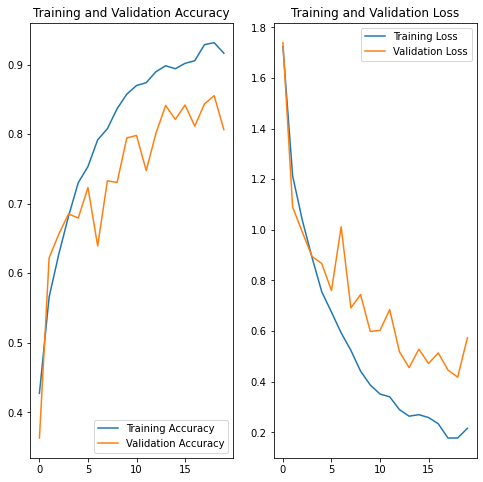

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We see as compared to previous models , accuracy and loss over training and validation set shows steady increase and decrease. The model exhibits similar learning curve path over train and validation set, it's just that model performanc over validation set is more volatile. There is a bit over-fitting seen.